In [1]:
from utils import load_combined_df

combined = load_combined_df()

X_cols = ['VH', 'VV', 'HH', 'HV', 'Angle']
y_col = ['SM (Combined)']

num_features = len(X_cols)

2025-10-06 01:13:10.478895: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loaded combined DF with shape: (745, 16)


In [2]:
import pandas as pd

def process_experiment_results(hyperparam_name: str, combined_results: list):
    all_runs_data = []
    for run_number, run_dict in enumerate(combined_results):
        for param_value, results in run_dict.items():
            row = {
                'run': run_number + 1,
                hyperparam_name: param_value,
                'test_PICP': results['test_results']['PICP'],
                'test_MPIW': results['test_results']['MPIW'],
                'val_PICP': results['val_results']['PICP'],
                'val_MPIW': results['val_results']['MPIW'],
            }
            all_runs_data.append(row)

    run_by_run_df = pd.DataFrame(all_runs_data)

    aggregations = {
        'test_PICP': ['mean'],
        'test_MPIW': ['mean'],
        'val_PICP': ['mean'],
        'val_MPIW': ['mean'],
    }

    aggregated_df = run_by_run_df.groupby(hyperparam_name).agg(aggregations)

    aggregated_df.columns = ['_'.join(col).strip() for col in aggregated_df.columns.values]
    
    aggregated_df = aggregated_df.reset_index()

    column_order = [
        hyperparam_name,
        'test_PICP_mean', 'test_PICP_std',
        'val_PICP_mean', 'val_PICP_std',
        'test_MPIW_mean', 'test_MPIW_std',
        'val_MPIW_mean', 'val_MPIW_std',
    ]
    
    final_columns = [col for col in column_order if col in aggregated_df.columns]
    aggregated_df = aggregated_df[final_columns]

    return aggregated_df, run_by_run_df

def print_results(param, param_val, result_dict):
    test_picp = result_dict['test_results']['PICP']
    test_mpiw = result_dict['test_results']['MPIW']
    val_picp = result_dict['val_results']['PICP']
    val_mpiw = result_dict['val_results']['MPIW']
    
    # The formatted print line for this specific run's results
    print(f"  - {param}={param_val:<3}:  Test PICP: {test_picp*100:6.2f}% | Test MPIW: {test_mpiw:7.3f} || Val PICP: {val_picp*100:6.2f}% | Val MPIW: {val_mpiw:7.3f}")
        

## Finetuning value of `r`

In [4]:
from model_experiments import PredictionIntervalWithTubeLoss
from tensorflow import keras
import tensorflow as tf
from utils import model_to_string

model = tf.keras.Sequential([
    # Input layer
    tf.keras.Input(shape=(len(X_cols), )),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.09),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.09),
    tf.keras.layers.Dense(2)
])

r_vals = [0.1, 0.3, 0.5, 0.7, 0.9]
combined_results = []
NUM_EXPERIMENTS = 5

for i in range(NUM_EXPERIMENTS):
    print(f"-------- RUNNING EXPERIMENT {i+1} ----------\n")
    r_results = dict()
    for r in r_vals:
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=0.02,
            decay_steps=10000,
            decay_rate=0.01)
        opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

        param_string = model_to_string(model)

        pi = PredictionIntervalWithTubeLoss(combined, X_cols, y_col[0], satellite='EOS+Sentinel', r=r)

        results = pi.run_experiment(model=model, optimizer=opt, epochs=500, 
                                    model_param_string=param_string, plot_losses=False, plot_interval=False,
                                    return_preds=True)
        
        print_results("r", r, results)
        print()
        
        r_results[r] = results
        
    combined_results.append(r_results)

-------- RUNNING EXPERIMENT 1 ----------



Epochs:   4%|▎         | 18/500 [00:03<01:30,  5.30epoch/s, loss=1.6738, val_loss=1.0150]


  - r=0.1:  Test PICP:  97.33% | Test MPIW:  62.058 || Val PICP:  96.43% | Val MPIW:  62.602



Epochs:   8%|▊         | 39/500 [00:05<01:04,  7.10epoch/s, loss=0.9837, val_loss=0.8442]


  - r=0.3:  Test PICP:  96.00% | Test MPIW:  34.426 || Val PICP:  96.43% | Val MPIW:  34.848



Epochs:   3%|▎         | 13/500 [00:02<01:34,  5.17epoch/s, loss=0.8421, val_loss=0.7939]


  - r=0.5:  Test PICP:  98.67% | Test MPIW:  50.502 || Val PICP:  95.24% | Val MPIW:  50.994



Epochs:   3%|▎         | 16/500 [00:02<01:04,  7.52epoch/s, loss=0.8463, val_loss=0.7594]


  - r=0.7:  Test PICP:  98.67% | Test MPIW:  71.614 || Val PICP:  94.64% | Val MPIW:  72.163



Epochs:   3%|▎         | 16/500 [00:02<01:02,  7.79epoch/s, loss=0.8571, val_loss=0.7580]


  - r=0.9:  Test PICP:  98.67% | Test MPIW:  69.898 || Val PICP:  95.24% | Val MPIW:  70.681

-------- RUNNING EXPERIMENT 2 ----------



Epochs:   3%|▎         | 15/500 [00:01<01:03,  7.63epoch/s, loss=1.4076, val_loss=0.9858]


  - r=0.1:  Test PICP:  93.33% | Test MPIW:  42.492 || Val PICP:  95.24% | Val MPIW:  42.875



Epochs:   6%|▌         | 29/500 [00:03<00:58,  8.02epoch/s, loss=1.2348, val_loss=0.8893]


  - r=0.3:  Test PICP:  97.33% | Test MPIW:  36.151 || Val PICP:  96.43% | Val MPIW:  36.524



Epochs:   9%|▉         | 45/500 [00:04<00:45,  9.90epoch/s, loss=0.7269, val_loss=0.6554]


  - r=0.5:  Test PICP:  97.33% | Test MPIW:  36.457 || Val PICP:  97.02% | Val MPIW:  36.918



Epochs:  18%|█▊        | 89/500 [00:09<00:43,  9.55epoch/s, loss=0.7894, val_loss=0.7477]


  - r=0.7:  Test PICP:  97.33% | Test MPIW: 113.334 || Val PICP:  95.24% | Val MPIW: 114.653



Epochs:   5%|▍         | 24/500 [00:03<01:15,  6.32epoch/s, loss=0.8536, val_loss=0.7567]


  - r=0.9:  Test PICP:  98.67% | Test MPIW:  85.376 || Val PICP:  95.24% | Val MPIW:  86.134

-------- RUNNING EXPERIMENT 3 ----------



Epochs:  11%|█         | 53/500 [00:06<00:55,  8.08epoch/s, loss=1.3165, val_loss=0.9301]


  - r=0.1:  Test PICP:  97.33% | Test MPIW:  49.096 || Val PICP:  95.24% | Val MPIW:  49.483



Epochs:   8%|▊         | 42/500 [00:05<00:58,  7.82epoch/s, loss=1.4675, val_loss=0.8912]


  - r=0.3:  Test PICP:  97.33% | Test MPIW:  36.394 || Val PICP:  97.02% | Val MPIW:  36.800



Epochs:   4%|▍         | 19/500 [00:02<01:11,  6.72epoch/s, loss=0.9610, val_loss=0.7447]


  - r=0.5:  Test PICP:  98.67% | Test MPIW:  61.842 || Val PICP:  95.24% | Val MPIW:  62.546



Epochs:   6%|▌         | 31/500 [00:03<00:51,  9.19epoch/s, loss=0.8445, val_loss=0.7948]


  - r=0.7:  Test PICP:  98.67% | Test MPIW:  73.722 || Val PICP:  94.64% | Val MPIW:  74.644



Epochs:  20%|█▉        | 99/500 [00:10<00:42,  9.42epoch/s, loss=0.8006, val_loss=0.7428]


  - r=0.9:  Test PICP:  96.00% | Test MPIW:  83.897 || Val PICP:  95.24% | Val MPIW:  84.692

-------- RUNNING EXPERIMENT 4 ----------



Epochs:  13%|█▎        | 64/500 [00:08<00:55,  7.91epoch/s, loss=1.1309, val_loss=0.9619]


  - r=0.1:  Test PICP:  94.67% | Test MPIW:  45.912 || Val PICP:  95.24% | Val MPIW:  46.203



Epochs:  10%|▉         | 49/500 [00:06<01:00,  7.50epoch/s, loss=0.9953, val_loss=0.9027]


  - r=0.3:  Test PICP:  97.33% | Test MPIW:  35.104 || Val PICP:  95.83% | Val MPIW:  35.360



Epochs:   2%|▏         | 12/500 [00:02<01:59,  4.07epoch/s, loss=0.7934, val_loss=0.7421]


  - r=0.5:  Test PICP:  96.00% | Test MPIW:  31.389 || Val PICP:  93.45% | Val MPIW:  31.763



Epochs:  14%|█▎        | 68/500 [00:07<00:44,  9.61epoch/s, loss=0.8157, val_loss=0.7556]


  - r=0.7:  Test PICP:  97.33% | Test MPIW:  84.088 || Val PICP:  95.24% | Val MPIW:  84.674



Epochs:   9%|▊         | 43/500 [00:05<01:03,  7.25epoch/s, loss=0.7765, val_loss=0.7528]


  - r=0.9:  Test PICP:  97.33% | Test MPIW: 108.927 || Val PICP:  94.64% | Val MPIW: 109.932

-------- RUNNING EXPERIMENT 5 ----------



Epochs:   3%|▎         | 17/500 [00:03<01:26,  5.60epoch/s, loss=2.1306, val_loss=1.0797]


  - r=0.1:  Test PICP:  97.33% | Test MPIW:  46.561 || Val PICP:  97.02% | Val MPIW:  47.157



Epochs:  17%|█▋        | 83/500 [00:08<00:40, 10.32epoch/s, loss=0.9527, val_loss=0.8397]


  - r=0.3:  Test PICP:  94.67% | Test MPIW:  34.327 || Val PICP:  95.83% | Val MPIW:  34.557



Epochs:  10%|▉         | 48/500 [00:06<00:57,  7.81epoch/s, loss=0.7337, val_loss=0.7101]


  - r=0.5:  Test PICP:  98.67% | Test MPIW:  42.776 || Val PICP:  96.43% | Val MPIW:  43.078



Epochs:  18%|█▊        | 89/500 [00:10<00:47,  8.64epoch/s, loss=0.7633, val_loss=0.7434]


  - r=0.7:  Test PICP:  96.00% | Test MPIW: 125.156 || Val PICP:  95.24% | Val MPIW: 126.547



Epochs:   7%|▋         | 33/500 [00:04<00:59,  7.79epoch/s, loss=0.8402, val_loss=0.7555]


  - r=0.9:  Test PICP:  98.67% | Test MPIW:  99.650 || Val PICP:  95.24% | Val MPIW: 100.984



In [5]:
aggregated_metrics_r, all_metrics_r = process_experiment_results("r", combined_results)

In [6]:
aggregated_metrics_r

,r,test_PICP_mean,val_PICP_mean,test_MPIW_mean,val_MPIW_mean
0,0.1,0.960000,0.958333,49.223801,49.664001
1,0.3,0.965333,0.963095,35.280403,35.617798
2,0.5,0.978667,0.954762,44.593201,45.059799
3,0.7,0.976000,0.950000,93.582802,94.536201
4,0.9,0.978667,0.951190,89.549606,90.484604


## Finetuning value of `delta`

In [7]:
from model_experiments import PredictionIntervalWithTubeLoss
from tensorflow import keras
model = tf.keras.Sequential([
    # Input layer
    tf.keras.Input(shape=(len(X_cols), )),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.09),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.09),
    tf.keras.layers.Dense(2)
])


delta_vals = [0, 0.01, 0.05, 0.1, 0.2]
combined_results = []

for i in range(NUM_EXPERIMENTS):
    print(f"\n------------ RUNNING EXPERIMENT {i+1} ----------------\n")
    delta_results = dict()
    for delta in delta_vals:
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=0.02,
            decay_steps=10000,
            decay_rate=0.01)
        opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

        param_string = model_to_string(model)

        pi = PredictionIntervalWithTubeLoss(combined, X_cols, y_col[0], satellite='EOS+Sentinel', r=0.3, delta=delta)

        results = pi.run_experiment(model=model, optimizer=opt, epochs=500, 
                                    model_param_string=param_string, plot_losses=False, plot_interval=False,
                                    return_preds=True)
        
        print_results("delta", delta, results)
        print()
        
        delta_results[delta] = results
    combined_results.append(delta_results)


------------ RUNNING EXPERIMENT 1 ----------------



Epochs:   5%|▌         | 26/500 [00:04<01:20,  5.88epoch/s, loss=1.3143, val_loss=0.8773]


  - delta=0  :  Test PICP:  97.33% | Test MPIW:  35.489 || Val PICP:  96.43% | Val MPIW:  35.899



Epochs:   3%|▎         | 16/500 [00:02<01:26,  5.61epoch/s, loss=1.5057, val_loss=1.2047]


  - delta=0.01:  Test PICP:  94.67% | Test MPIW:  31.178 || Val PICP:  94.05% | Val MPIW:  31.569



Epochs:   7%|▋         | 36/500 [00:05<01:07,  6.87epoch/s, loss=2.8991, val_loss=2.1922]


  - delta=0.05:  Test PICP:  80.00% | Test MPIW:  22.758 || Val PICP:  85.12% | Val MPIW:  22.991



Epochs:   3%|▎         | 15/500 [00:02<01:30,  5.37epoch/s, loss=3.8653, val_loss=3.2156]


  - delta=0.1:  Test PICP:  65.33% | Test MPIW:  17.572 || Val PICP:  74.40% | Val MPIW:  17.808



Epochs:  10%|▉         | 48/500 [00:05<00:52,  8.68epoch/s, loss=5.0417, val_loss=4.4156]


  - delta=0.2:  Test PICP:  48.00% | Test MPIW:  11.231 || Val PICP:  56.55% | Val MPIW:  11.338


------------ RUNNING EXPERIMENT 2 ----------------



Epochs:   6%|▌         | 29/500 [00:03<00:52,  8.95epoch/s, loss=1.0929, val_loss=0.8816]


  - delta=0  :  Test PICP:  97.33% | Test MPIW:  34.677 || Val PICP:  96.43% | Val MPIW:  34.983



Epochs:   6%|▌         | 28/500 [00:03<00:52,  8.92epoch/s, loss=1.5115, val_loss=1.2133]


  - delta=0.01:  Test PICP:  96.00% | Test MPIW:  32.009 || Val PICP:  94.05% | Val MPIW:  32.343



Epochs:   5%|▍         | 24/500 [00:02<00:54,  8.70epoch/s, loss=2.5433, val_loss=2.2358]


  - delta=0.05:  Test PICP:  84.00% | Test MPIW:  23.528 || Val PICP:  86.90% | Val MPIW:  23.775



Epochs:   6%|▌         | 31/500 [00:03<00:51,  9.17epoch/s, loss=3.5431, val_loss=3.2084]


  - delta=0.1:  Test PICP:  70.67% | Test MPIW:  17.841 || Val PICP:  76.19% | Val MPIW:  18.044



Epochs:   6%|▌         | 30/500 [00:03<00:54,  8.67epoch/s, loss=4.8746, val_loss=4.4605]


  - delta=0.2:  Test PICP:  49.33% | Test MPIW:  11.243 || Val PICP:  55.95% | Val MPIW:  11.401


------------ RUNNING EXPERIMENT 3 ----------------



Epochs:  13%|█▎        | 63/500 [00:06<00:46,  9.43epoch/s, loss=0.9962, val_loss=0.8643]


  - delta=0  :  Test PICP:  97.33% | Test MPIW:  34.988 || Val PICP:  97.02% | Val MPIW:  35.299



Epochs:  11%|█         | 56/500 [00:07<00:55,  7.98epoch/s, loss=1.2635, val_loss=1.1699]


  - delta=0.01:  Test PICP:  93.33% | Test MPIW:  30.721 || Val PICP:  94.64% | Val MPIW:  30.972



Epochs:  12%|█▏        | 60/500 [00:06<00:46,  9.39epoch/s, loss=2.4913, val_loss=2.1323]


  - delta=0.05:  Test PICP:  81.33% | Test MPIW:  23.500 || Val PICP:  86.31% | Val MPIW:  23.724



Epochs:  10%|▉         | 48/500 [00:06<00:59,  7.55epoch/s, loss=3.5697, val_loss=3.1262]


  - delta=0.1:  Test PICP:  74.67% | Test MPIW:  18.058 || Val PICP:  76.79% | Val MPIW:  18.215



Epochs:  12%|█▏        | 58/500 [00:07<00:53,  8.23epoch/s, loss=5.0755, val_loss=4.4391]


  - delta=0.2:  Test PICP:  49.33% | Test MPIW:  11.685 || Val PICP:  57.14% | Val MPIW:  11.805


------------ RUNNING EXPERIMENT 4 ----------------



Epochs:  13%|█▎        | 67/500 [00:08<00:54,  7.96epoch/s, loss=1.1267, val_loss=0.8288]


  - delta=0  :  Test PICP:  93.33% | Test MPIW:  34.708 || Val PICP:  95.83% | Val MPIW:  34.979



Epochs:   8%|▊         | 39/500 [00:05<01:04,  7.17epoch/s, loss=1.3493, val_loss=1.2082]


  - delta=0.01:  Test PICP:  97.33% | Test MPIW:  30.704 || Val PICP:  93.45% | Val MPIW:  30.930



Epochs:   6%|▌         | 30/500 [00:04<01:09,  6.72epoch/s, loss=2.9591, val_loss=2.2325]


  - delta=0.05:  Test PICP:  84.00% | Test MPIW:  23.655 || Val PICP:  87.50% | Val MPIW:  23.918



Epochs:  12%|█▏        | 59/500 [00:07<00:54,  8.16epoch/s, loss=3.5131, val_loss=3.1010]


  - delta=0.1:  Test PICP:  74.67% | Test MPIW:  18.092 || Val PICP:  77.98% | Val MPIW:  18.220



Epochs:   9%|▉         | 46/500 [00:06<01:03,  7.13epoch/s, loss=5.2075, val_loss=4.4624]


  - delta=0.2:  Test PICP:  53.33% | Test MPIW:  12.261 || Val PICP:  57.74% | Val MPIW:  12.396


------------ RUNNING EXPERIMENT 5 ----------------



Epochs:   4%|▎         | 18/500 [00:03<01:24,  5.69epoch/s, loss=1.4878, val_loss=0.9610]


  - delta=0  :  Test PICP:  97.33% | Test MPIW:  34.946 || Val PICP:  96.43% | Val MPIW:  35.344



Epochs:  10%|█         | 50/500 [00:05<00:48,  9.29epoch/s, loss=1.3867, val_loss=1.1949]


  - delta=0.01:  Test PICP:  89.33% | Test MPIW:  28.721 || Val PICP:  93.45% | Val MPIW:  28.920



Epochs:  10%|█         | 50/500 [00:05<00:48,  9.30epoch/s, loss=2.5485, val_loss=2.2386]


  - delta=0.05:  Test PICP:  80.00% | Test MPIW:  22.560 || Val PICP:  85.12% | Val MPIW:  22.703



Epochs:  10%|▉         | 48/500 [00:05<00:53,  8.46epoch/s, loss=3.5574, val_loss=3.0871]


  - delta=0.1:  Test PICP:  74.67% | Test MPIW:  17.590 || Val PICP:  74.40% | Val MPIW:  17.746



Epochs:   7%|▋         | 37/500 [00:04<01:01,  7.48epoch/s, loss=5.3539, val_loss=4.4893]


  - delta=0.2:  Test PICP:  50.67% | Test MPIW:  11.737 || Val PICP:  56.55% | Val MPIW:  11.858



In [8]:
aggegated_metrics_delta, all_metrics_delta = process_experiment_results("delta", combined_results)

In [9]:
aggegated_metrics_delta

,delta,test_PICP_mean,val_PICP_mean,test_MPIW_mean,val_MPIW_mean
0,0.00,0.965333,0.964286,34.961601,35.300800
1,0.01,0.941333,0.939286,30.666601,30.946798
2,0.05,0.818667,0.861905,23.200199,23.422199
3,0.10,0.720000,0.759524,17.830601,18.006601
4,0.20,0.501333,0.567857,11.631400,11.759600


## Experimenting With Features

In [19]:
X_cols = ['VH', 'HH', 'Angle']

In [20]:
from model_experiments import PredictionIntervalWithTubeLoss
from tensorflow import keras
import tensorflow as tf
from utils import model_to_string

model = tf.keras.Sequential([
    # Input layer
    tf.keras.Input(shape=(len(X_cols), )),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.09),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.09),
    tf.keras.layers.Dense(2)
])

r_vals = [0.1, 0.3, 0.5, 0.7, 0.9]
combined_results = []
NUM_EXPERIMENTS = 5

for i in range(NUM_EXPERIMENTS):
    print(f"-------- RUNNING EXPERIMENT {i+1} ----------\n")
    r_results = dict()
    for r in r_vals:
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=0.02,
            decay_steps=10000,
            decay_rate=0.01)
        opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

        param_string = model_to_string(model)

        pi = PredictionIntervalWithTubeLoss(combined, X_cols, y_col[0], satellite='EOS+Sentinel', r=r)

        results = pi.run_experiment(model=model, optimizer=opt, epochs=500, 
                                    model_param_string=param_string, plot_losses=False, plot_interval=False,
                                    return_preds=True)
        
        print_results("r", r, results)
        print()
        
        r_results[r] = results
        
    combined_results.append(r_results)

aggregated_metrics_r, all_metrics_r = process_experiment_results("r", combined_results)

-------- RUNNING EXPERIMENT 1 ----------




































































Epochs:   6%|▋         | 32/500 [00:04<01:11,  6.57epoch/s, loss=1.1977, val_loss=0.9465]


  - r=0.1:  Test PICP:  92.00% | Test MPIW:  54.136 || Val PICP:  95.24% | Val MPIW:  54.889














































































Epochs:   7%|▋         | 37/500 [00:05<01:07,  6.83epoch/s, loss=1.1139, val_loss=0.8850]


  - r=0.3:  Test PICP:  94.67% | Test MPIW:  35.008 || Val PICP:  97.02% | Val MPIW:  35.466


































Epochs:   3%|▎         | 15/500 [00:02<01:30,  5.35epoch/s, loss=0.8205, val_loss=0.7606]


  - r=0.5:  Test PICP:  98.67% | Test MPIW:  52.124 || Val PICP:  96.43% | Val MPIW:  52.746




























































Epochs:   7%|▋         | 35/500 [00:04<00:59,  7.82epoch/s, loss=0.8347, val_loss=0.7662]


  - r=0.7:  Test PICP:  96.00% | Test MPIW:  69.484 || Val PICP:  95.24% | Val MPIW:  70.453






















































Epochs:   7%|▋         | 33/500 [00:03<00:52,  8.86epoch/s, loss=0.8006, val_loss=0.7576]


  - r=0.9:  Test PICP:  97.33% | Test MPIW:  77.301 || Val PICP:  95.24% | Val MPIW:  78.259

-------- RUNNING EXPERIMENT 2 ----------

































































































Epochs:  12%|█▏        | 59/500 [00:06<00:45,  9.65epoch/s, loss=1.1017, val_loss=0.8992]


  - r=0.1:  Test PICP:  94.67% | Test MPIW:  49.275 || Val PICP:  95.83% | Val MPIW:  49.802














































































































































































Epochs:  17%|█▋        | 85/500 [00:10<00:51,  8.03epoch/s, loss=0.9798, val_loss=0.8395]


  - r=0.3:  Test PICP:  97.33% | Test MPIW:  33.634 || Val PICP:  95.83% | Val MPIW:  33.932






























Epochs:   3%|▎         | 13/500 [00:02<01:37,  4.98epoch/s, loss=0.8653, val_loss=0.7578]


  - r=0.5:  Test PICP:  98.67% | Test MPIW:  52.978 || Val PICP:  95.83% | Val MPIW:  53.682
























Epochs:   3%|▎         | 13/500 [00:02<01:14,  6.49epoch/s, loss=0.8748, val_loss=0.7723]


  - r=0.7:  Test PICP:  98.67% | Test MPIW:  48.342 || Val PICP:  96.43% | Val MPIW:  48.993

























































Epochs:   7%|▋         | 35/500 [00:03<00:49,  9.35epoch/s, loss=0.7997, val_loss=0.7631]


  - r=0.9:  Test PICP:  97.33% | Test MPIW:  86.620 || Val PICP:  95.24% | Val MPIW:  87.714

-------- RUNNING EXPERIMENT 3 ----------



































































































Epochs:  12%|█▏        | 58/500 [00:06<00:48,  9.05epoch/s, loss=1.0926, val_loss=0.9421]


  - r=0.1:  Test PICP:  93.33% | Test MPIW:  43.402 || Val PICP:  95.24% | Val MPIW:  43.790




















































































Epochs:   8%|▊         | 40/500 [00:05<01:03,  7.21epoch/s, loss=1.0245, val_loss=0.8497]


  - r=0.3:  Test PICP:  94.67% | Test MPIW:  34.634 || Val PICP:  95.83% | Val MPIW:  35.102























Epochs:   2%|▏         | 12/500 [00:02<01:31,  5.31epoch/s, loss=0.8235, val_loss=0.7934]


  - r=0.5:  Test PICP:  97.33% | Test MPIW:  35.056 || Val PICP:  97.02% | Val MPIW:  35.490





























































Epochs:   8%|▊         | 38/500 [00:04<00:48,  9.49epoch/s, loss=0.8036, val_loss=0.7577]


  - r=0.7:  Test PICP:  96.00% | Test MPIW:  78.806 || Val PICP:  95.83% | Val MPIW:  79.803
















































Epochs:   6%|▌         | 29/500 [00:03<00:52,  9.05epoch/s, loss=0.9417, val_loss=0.7621]


  - r=0.9:  Test PICP:  97.33% | Test MPIW:  79.817 || Val PICP:  95.24% | Val MPIW:  81.008

-------- RUNNING EXPERIMENT 4 ----------































































Epochs:   8%|▊         | 39/500 [00:04<00:48,  9.52epoch/s, loss=1.1857, val_loss=0.9073]


  - r=0.1:  Test PICP:  93.33% | Test MPIW:  41.652 || Val PICP:  95.24% | Val MPIW:  42.123
























Epochs:   3%|▎         | 13/500 [00:02<01:22,  5.94epoch/s, loss=1.6508, val_loss=1.0063]


  - r=0.3:  Test PICP:  96.00% | Test MPIW:  34.580 || Val PICP:  96.43% | Val MPIW:  35.044




Epochs:   1%|          | 5/500 [23:23<38:36:09, 280.75s/epoch, loss=0.7740, val_loss=0.7912]


























Epochs:   3%|▎         | 13/500 [00:03<02:15,  3.60epoch/s, loss=0.9179, val_loss=0.7677]


  - r=0.5:  Test PICP:  94.67% | Test MPIW:  31.455 || Val PICP:  92.26% | Val MPIW:  31.709



Epochs:   3%|▎         | 15/500 [00:02<01:10,  6.93epoch/s, loss=0.8303, val_loss=0.7612] 


  - r=0.7:  Test PICP:  96.00% | Test MPIW:  65.112 || Val PICP:  94.05% | Val MPIW:  66.057



Epochs:  14%|█▎        | 68/500 [00:07<00:46,  9.28epoch/s, loss=0.8219, val_loss=0.7783] 


  - r=0.9:  Test PICP:  96.00% | Test MPIW:  91.222 || Val PICP:  95.24% | Val MPIW:  92.532

-------- RUNNING EXPERIMENT 5 ----------



Epochs:  13%|█▎        | 66/500 [00:08<00:57,  7.59epoch/s, loss=1.2537, val_loss=0.9146] 


  - r=0.1:  Test PICP:  94.67% | Test MPIW:  45.735 || Val PICP:  95.24% | Val MPIW:  46.117



Epochs:   6%|▌         | 31/500 [00:04<01:09,  6.75epoch/s, loss=1.1327, val_loss=0.8606] 


  - r=0.3:  Test PICP:  96.00% | Test MPIW:  35.239 || Val PICP:  97.02% | Val MPIW:  35.647



Epochs:   2%|▏         | 12/500 [00:02<01:36,  5.03epoch/s, loss=0.8372, val_loss=0.7620] 


  - r=0.5:  Test PICP:  97.33% | Test MPIW:  36.725 || Val PICP:  97.02% | Val MPIW:  37.217



Epochs:   8%|▊         | 38/500 [00:04<00:48,  9.49epoch/s, loss=0.8285, val_loss=0.7628] 


  - r=0.7:  Test PICP:  97.33% | Test MPIW:  94.531 || Val PICP:  95.24% | Val MPIW:  95.786



Epochs:   8%|▊         | 40/500 [00:04<00:53,  8.66epoch/s, loss=0.8627, val_loss=0.7936] 


  - r=0.9:  Test PICP:  97.33% | Test MPIW:  84.982 || Val PICP:  95.83% | Val MPIW:  86.154



In [21]:
aggregated_metrics_r

,r,test_PICP_mean,val_PICP_mean,test_MPIW_mean,val_MPIW_mean
0,0.1,0.936000,0.953571,46.840004,47.344200
1,0.3,0.957333,0.964286,34.618999,35.038200
2,0.5,0.973333,0.957143,41.667599,42.168800
3,0.7,0.968000,0.953571,71.254997,72.218399
4,0.9,0.970667,0.953571,83.988403,85.133400


In [22]:
from model_experiments import PredictionIntervalWithTubeLoss
from tensorflow import keras
model = tf.keras.Sequential([
    # Input layer
    tf.keras.Input(shape=(len(X_cols), )),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.09),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.09),
    tf.keras.layers.Dense(2)
])


delta_vals = [0, 0.01, 0.05, 0.1, 0.2]
combined_results = []

for i in range(NUM_EXPERIMENTS):
    print(f"\n------------ RUNNING EXPERIMENT {i+1} ----------------\n")
    delta_results = dict()
    for delta in delta_vals:
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=0.02,
            decay_steps=10000,
            decay_rate=0.01)
        opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

        param_string = model_to_string(model)

        pi = PredictionIntervalWithTubeLoss(combined, X_cols, y_col[0], satellite='EOS+Sentinel', r=0.3, delta=delta)

        results = pi.run_experiment(model=model, optimizer=opt, epochs=500, 
                                    model_param_string=param_string, plot_losses=False, plot_interval=False,
                                    return_preds=True)
        
        print_results("delta", delta, results)
        print()
        
        delta_results[delta] = results
    combined_results.append(delta_results)

aggegated_metrics_delta, all_metrics_delta = process_experiment_results("delta", combined_results)


------------ RUNNING EXPERIMENT 1 ----------------



Epochs:   8%|▊         | 38/500 [00:05<01:08,  6.74epoch/s, loss=1.0726, val_loss=0.9807] 


  - delta=0  :  Test PICP:  96.00% | Test MPIW:  35.681 || Val PICP:  97.02% | Val MPIW:  36.050



Epochs:   5%|▍         | 24/500 [00:03<01:16,  6.20epoch/s, loss=1.4297, val_loss=1.2025] 


  - delta=0.01:  Test PICP:  93.33% | Test MPIW:  32.466 || Val PICP:  95.24% | Val MPIW:  32.942



Epochs:   7%|▋         | 33/500 [00:04<01:06,  7.04epoch/s, loss=2.4287, val_loss=2.1387] 


  - delta=0.05:  Test PICP:  82.67% | Test MPIW:  22.823 || Val PICP:  86.90% | Val MPIW:  23.110



Epochs:   9%|▉         | 45/500 [00:06<01:02,  7.32epoch/s, loss=3.6720, val_loss=3.0872] 


  - delta=0.1:  Test PICP:  73.33% | Test MPIW:  18.545 || Val PICP:  79.17% | Val MPIW:  18.767



Epochs:   8%|▊         | 40/500 [00:05<01:01,  7.52epoch/s, loss=5.2486, val_loss=4.4660] 


  - delta=0.2:  Test PICP:  50.67% | Test MPIW:  11.860 || Val PICP:  55.95% | Val MPIW:  12.043


------------ RUNNING EXPERIMENT 2 ----------------



Epochs:  11%|█         | 53/500 [00:06<00:57,  7.80epoch/s, loss=1.1099, val_loss=0.8626] 


  - delta=0  :  Test PICP:  96.00% | Test MPIW:  34.581 || Val PICP:  95.83% | Val MPIW:  34.866



Epochs:   7%|▋         | 35/500 [00:05<01:06,  6.97epoch/s, loss=1.3897, val_loss=1.1741] 


  - delta=0.01:  Test PICP:  94.67% | Test MPIW:  31.922 || Val PICP:  95.83% | Val MPIW:  32.248



Epochs:   9%|▉         | 45/500 [00:06<01:01,  7.40epoch/s, loss=2.3515, val_loss=2.1283] 


  - delta=0.05:  Test PICP:  80.00% | Test MPIW:  23.156 || Val PICP:  87.50% | Val MPIW:  23.412



Epochs:   9%|▉         | 47/500 [00:06<01:00,  7.49epoch/s, loss=3.4256, val_loss=3.1047] 


  - delta=0.1:  Test PICP:  72.00% | Test MPIW:  17.724 || Val PICP:  77.38% | Val MPIW:  17.964



Epochs:   8%|▊         | 38/500 [00:05<01:05,  7.05epoch/s, loss=5.6569, val_loss=4.5005] 


  - delta=0.2:  Test PICP:  52.00% | Test MPIW:  12.179 || Val PICP:  56.55% | Val MPIW:  12.365


------------ RUNNING EXPERIMENT 3 ----------------



Epochs:   5%|▍         | 24/500 [00:03<01:13,  6.45epoch/s, loss=1.2384, val_loss=0.9023] 


  - delta=0  :  Test PICP:  97.33% | Test MPIW:  36.566 || Val PICP:  97.02% | Val MPIW:  36.829



Epochs:   6%|▌         | 28/500 [00:04<01:10,  6.72epoch/s, loss=1.6335, val_loss=1.2985] 


  - delta=0.01:  Test PICP:  93.33% | Test MPIW:  30.352 || Val PICP:  94.64% | Val MPIW:  30.671



Epochs:   8%|▊         | 38/500 [00:04<01:00,  7.66epoch/s, loss=3.0178, val_loss=2.2130] 


  - delta=0.05:  Test PICP:  82.67% | Test MPIW:  22.537 || Val PICP:  86.90% | Val MPIW:  22.775



Epochs:   6%|▌         | 31/500 [00:04<01:06,  7.01epoch/s, loss=3.6975, val_loss=3.1155] 


  - delta=0.1:  Test PICP:  73.33% | Test MPIW:  18.159 || Val PICP:  79.17% | Val MPIW:  18.373



Epochs:   7%|▋         | 34/500 [00:04<01:02,  7.51epoch/s, loss=5.0095, val_loss=4.5280] 


  - delta=0.2:  Test PICP:  49.33% | Test MPIW:  11.623 || Val PICP:  54.76% | Val MPIW:  11.821


------------ RUNNING EXPERIMENT 4 ----------------



Epochs:  10%|█         | 50/500 [00:06<00:56,  7.97epoch/s, loss=1.2047, val_loss=0.8893] 


  - delta=0  :  Test PICP:  97.33% | Test MPIW:  35.914 || Val PICP:  96.43% | Val MPIW:  36.238



Epochs:  10%|▉         | 49/500 [00:06<00:58,  7.67epoch/s, loss=1.3264, val_loss=1.1555] 


  - delta=0.01:  Test PICP:  90.67% | Test MPIW:  29.907 || Val PICP:  94.64% | Val MPIW:  30.195



Epochs:   7%|▋         | 34/500 [00:04<01:06,  6.97epoch/s, loss=2.5465, val_loss=2.2033] 


  - delta=0.05:  Test PICP:  82.67% | Test MPIW:  23.898 || Val PICP:  88.10% | Val MPIW:  24.190



Epochs:   6%|▌         | 28/500 [00:04<01:08,  6.89epoch/s, loss=3.6949, val_loss=3.1032] 


  - delta=0.1:  Test PICP:  77.33% | Test MPIW:  18.275 || Val PICP:  76.19% | Val MPIW:  18.464



Epochs:   5%|▌         | 26/500 [00:03<00:57,  8.19epoch/s, loss=5.7790, val_loss=4.5485] 


  - delta=0.2:  Test PICP:  52.00% | Test MPIW:  11.784 || Val PICP:  55.36% | Val MPIW:  11.966


------------ RUNNING EXPERIMENT 5 ----------------



Epochs:  10%|█         | 50/500 [00:05<00:47,  9.44epoch/s, loss=1.2853, val_loss=0.9565] 


  - delta=0  :  Test PICP:  97.33% | Test MPIW:  36.211 || Val PICP:  97.02% | Val MPIW:  36.549



Epochs:   7%|▋         | 33/500 [00:04<01:09,  6.69epoch/s, loss=1.5519, val_loss=1.1477] 


  - delta=0.01:  Test PICP:  94.67% | Test MPIW:  30.880 || Val PICP:  94.64% | Val MPIW:  31.184



Epochs:   3%|▎         | 15/500 [00:02<01:28,  5.47epoch/s, loss=2.7891, val_loss=2.2281] 


  - delta=0.05:  Test PICP:  77.33% | Test MPIW:  22.273 || Val PICP:  82.74% | Val MPIW:  22.600



Epochs:   6%|▌         | 29/500 [00:03<01:04,  7.28epoch/s, loss=3.6205, val_loss=3.1492] 


  - delta=0.1:  Test PICP:  72.00% | Test MPIW:  17.857 || Val PICP:  76.19% | Val MPIW:  18.082



Epochs:   7%|▋         | 34/500 [00:04<00:58,  7.96epoch/s, loss=4.8031, val_loss=4.4452] 


  - delta=0.2:  Test PICP:  48.00% | Test MPIW:  11.219 || Val PICP:  54.17% | Val MPIW:  11.402



In [23]:
aggegated_metrics_delta

,delta,test_PICP_mean,val_PICP_mean,test_MPIW_mean,val_MPIW_mean
0,0.00,0.968000,0.966667,35.790600,36.106400
1,0.01,0.933333,0.950000,31.105398,31.448002
2,0.05,0.810667,0.864286,22.937401,23.217402
3,0.10,0.736000,0.776190,18.112000,18.330000
4,0.20,0.504000,0.553571,11.733000,11.919400


## Running Final Experiments

In [2]:
X_cols = ['VH', 'HH', 'Angle']

Epochs:   5%|▌         | 27/500 [00:04<01:13,  6.48epoch/s, loss=1.6177, val_loss=1.1920] 


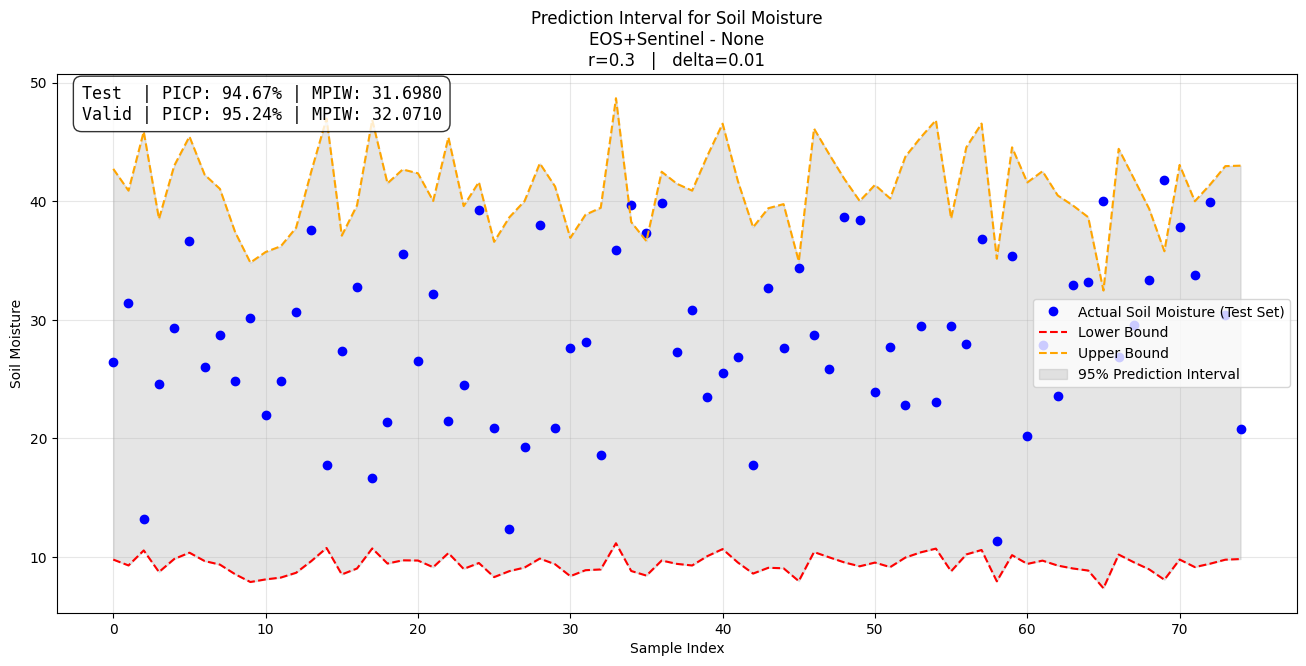

In [3]:
import tensorflow as tf
from utils import model_to_string
from model_experiments import PredictionIntervalWithTubeLoss

model = tf.keras.Sequential([
    # Input layer
    tf.keras.Input(shape=(len(X_cols), )),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.09),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.09),
    tf.keras.layers.Dense(2)
])

r=0.3
delta=0.01

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.02,
    decay_steps=10000,
    decay_rate=0.01)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

param_string = model_to_string(model)

pi = PredictionIntervalWithTubeLoss(combined, X_cols, y_col[0], satellite='EOS+Sentinel', r=0.3, delta=delta)

results = pi.run_experiment(model=model, optimizer=opt, epochs=500, return_preds=True)
pi.plot_prediction_interval_3d('HH', 'Angle', param_string)